In [1]:
encs = []
# buf = []
# with open('deidentified-medical-corpus.txt','r') as f:
#     for line in f:
#         line =line.replace('  ','').replace('\n','').lower().strip()
#         if '|||' in line:
#             if len(buf)!=0:
#                 encs.append(buf)
#             buf = []
#         else:
#             buf.append(line)
import glob
files = glob.glob('/Users/cbranzan/personal/enc1000/*')
for file_name in files:
    with open(file_name,'r') as f:
        encs.append(f.readlines())
encs.sort(key=len, reverse=False)
for enc in encs:
    if len(enc)<100:
        encs.remove(enc)
print len(encs)
enc=encs[50]
for line in enc:
        line =line.replace('  ','').replace('\n','').lower().strip()
        if len(line)<4:
            continue
        print line
print '-----------------------------------------------------------------------------'
print

878
nsg adm note
ms. [**known patient lastname 3763**] is a 52yo woman who was adm to micu for bs control on insulin drip.
pmh:iddmx20yrs, cva'[**27**],breast ca with mastectomy 89.
pt had a mva [**11-22**]: s/p sah(frontal&intracranial bleeds), left occipital non displaced fx, lower back pain, compression fx. pt was cleared to go home on [**11-27**]but returned <24hrs due to poor po intake,increased lethargy and ? failure to thrive. she was adm to the [**hospital ward name **] 5. this am, her bs was up 300's and than her bicarb was found to be 10. she was started on iv insulin.than was also found to have access issues. she cont to have poor po intake with some nausea. she was transfered for bs control on iv insulin
all:contrast dye, shell fish
meds:insulin, reglan, dilaudid
micu adm course:
endo:the ho placed a left ej piv-pt & husband very cautious about further invasive therapy- she was quickly given 2l ivf and insuliln drip started at 2u/hr. bs up to 400's and insulin drip titrated

In [2]:
import sys
sys.path.append('/Users/cbranzan/personal/QuickUMLS')
from quickumls import QuickUMLS
tagger = QuickUMLS('/Users/cbranzan/personal/QuickUMLS/data')

In [3]:
sems = {}
data=[]
with open('SemGroups_2013.txt','r') as f:
    for line in f:
        lines = line.replace('\n','').split('|')
        cat = lines[1]
        semtype = lines[2]
        desc = lines[3]
        sems[semtype]=(cat,desc)
        data.append([semtype,cat,desc])
import pandas as pd
sdf = pd.DataFrame(data=data,columns=['SemType','Category','Tag'])
sdf

,SemType,Category,Tag
0,T052,Activities & Behaviors,Activity
1,T053,Activities & Behaviors,Behavior
2,T056,Activities & Behaviors,Daily or Recreational Activity
3,T051,Activities & Behaviors,Event
4,T064,Activities & Behaviors,Governmental or Regulatory Activity
5,T055,Activities & Behaviors,Individual Behavior
6,T066,Activities & Behaviors,Machine Activity
7,T057,Activities & Behaviors,Occupational Activity
8,T054,Activities & Behaviors,Social Behavior
9,T017,Anatomy,Anatomical Structure


In [4]:
txt = ' '.join(encs[100])
tagger.window = 5
# for sem in sems:
#     tagger.accepted_semtypes.add(sem)
matches= tagger.match(txt, best_match=True, ignore_syntax=False)

stpwds = set()
doc = tagger.nlp(unicode(txt))
for token in doc:
    if token.is_stop:
        stpwds.add(token.idx)
        
    
import pandas as pd
tagged = {}
data = []
for match in matches:
#     print match
    semtypes = set()
    term = ''
    cui = ''
    ngram = ''
    mi=0
    for m in match:
        for s in m['semtypes']:
            semtypes.add(s)
        if m['similarity']>mi:
            term = m['term']
            cui = m['cui']
            mi=m['similarity']
            ngram = m['ngram']
    if len(term)<=2:
        continue
    if match[0]['start'] in stpwds:
        continue
    tmp=[]
    tmp.append(match[0]['start'])
    tmp.append(match[0]['end'])
    tmp.append(term)
    tmp.append(cui)
#     tmp.append(ngram)
#     tmp.append(match[0]['preferred'])
    tmp.append(mi)
    stypes = set()
    for sem in semtypes:
        stypes.add(sems[sem][1])
    tmp.append(stypes)
    tagged[term]=stypes
    data.append(tmp)
    
df_matches = pd.DataFrame(data=data, columns =['start','end','term','cui','similarity','semtypes'])

html='''<style>
   [data-entity] {
    padding: 0.25em 0.35em;
     margin: 0px 0.25em;
     line-height: 1;
     display: inline-block;
     border-radius: 0.25em;
     border: 0px solid;
    }

[data-entity]::after {
    box-sizing: border-box;
    content: attr(data-entity);
    font-size: 0.9em;
    line-height: 1;
    padding: 0.35em;
    border-radius: 0.35em;
    text-transform: uppercase;
    display: inline-block;
    vertical-align: middle;
    margin: 0px 0px 0.1rem 0.5rem;
    }
    '''
colors ={}
import random
def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color
cols = []
for sem in sems:
    tag_label = sems[sem][1].replace(' ','_').replace(',','_').replace('&','_and_')
    colors[tag_label]=generate_new_color(cols,pastel_factor = 0.1)
    
for lbls in tagged.values():
    for lbl in lbls:
#         print lbl
        tag_label = lbl.replace(' ','_').replace(',','_').replace('&','_and_')
        html+='''[data-entity][data-entity="'''+tag_label+'''"] {
                background: rgba('''+str(int(colors[tag_label][0]*255))+','+str(int(colors[tag_label][1]*255))+','+str(int(colors[tag_label][2]*255))+''', 0.6);
                border-color: rgb(166, 226, 45); 
                color:rgba(255,255,255,1.0);
                }\n'''
        
        
#         html+='[data-entity][data_entity="'+tag_label+'''"]::after {
#             background: rgba(66, '''+str(random.randint(0,255))+''', 45, 0.9);
#             }\n'''
        
html+='</style>'
html+='<div class = "mmm">'
tmp = txt
for tk in tagged:
    for tag in tagged[tk]:
        tmp = tmp.replace(tk,'<mark data-entity="'+tag.replace(' ','_').replace(',','_').replace('&','_and_')+'">'+tk+'</mark>')
html+=tmp
html+='</div>'
with open('tst.html','w') as f:
    f.write(html)
from IPython.display import display,HTML
display(HTML(html))
display(df_matches)

,start,end,term,cui,similarity,semtypes
0,1227,1254,Spontaneous breathing trial,C1828139,1.000000,{Therapeutic or Preventive Procedure}
1,4445,4467,respiratory depression,C0235063,1.000000,{Pathologic Function}
2,5865,5884,analgesic narcotics,C0027409,1.000000,{Pharmacologic Substance}
3,2645,2662,Review of Systems,C0489633,1.000000,{Health Care Activity}
4,6271,6288,Review of Systems,C0489633,1.000000,{Health Care Activity}
5,7735,7752,blood transfusion,C0005841,1.000000,"{Finding, Therapeutic or Preventive Procedure,..."
6,8075,8092,Review of Systems,C0489633,1.000000,{Health Care Activity}
7,9341,9358,Review of Systems,C0489633,1.000000,{Health Care Activity}
8,3937,3953,acute blood loss,C0333276,1.000000,{Pathologic Function}
9,4576,4592,vaginal bleeding,C2979982,1.000000,"{Finding, Disease or Syndrome}"


In [5]:
def process_encounter(enc_id,enc,tagger):
    stpwds = set()
    doc = tagger.nlp(unicode(enc))
    for token in doc:
        if token.is_stop:
            stpwds.add(token.idx)
    matches= tagger.match(enc, best_match=True, ignore_syntax=True)
    data = []
    for match in matches:
        semtypes = set()
        term = ''
        cui = ''
        ngram = ''
        mi=0
        for m in match:
            for s in m['semtypes']:
                semtypes.add(s)
            if m['similarity']>mi:
                term = m['term']
                cui = m['cui']
                mi=m['similarity']
                ngram = m['ngram']
        if len(term)<=2:
            continue
        if match[0]['start'] in stpwds:
            continue
        tmp=[]
        tmp.append(enc_id)
        tmp.append(match[0]['start'])
        tmp.append(match[0]['end'])
        tmp.append(term.lower())
        tmp.append(cui)
        tmp.append(mi)
        stypes = set()
        for sem in semtypes:
            stypes.add(sems[sem][1])
        tmp.append(stypes)
        data.append(tmp)
    return data


result = []
tagger.accepted_semtypes=set()
tagger.accepted_semtypes.add('T047') #Disease or Syndrome
tagger.accepted_semtypes.add('T184') # Sign or Symptom
for sem in sems:
    if sems[sem][0]=='Anatomy':
        tagger.accepted_semtypes.add(sem)
for sem in sems:
    if sems[sem][0]=='Chemicals & Drugs':
        tagger.accepted_semtypes.add(sem)

i=-1        
for enc in encs:
    try:
        i+=1
        annotations = process_encounter(i,' '.join(enc),tagger)
        result.extend(annotations)
    except Exception as e:
        print e
df_matches = pd.DataFrame(data=result, columns =['encounter','start','end','term','cui','similarity','semtypes'])
df_matches

'ascii' codec can't decode byte 0xef in position 1467: ordinal not in range(128)


'ascii' codec can't decode byte 0xef in position 2740: ordinal not in range(128)

'ascii' codec can't decode byte 0xef in position 2548: ordinal not in range(128)





'ascii' codec can't decode byte 0xef in position 1327: ordinal not in range(128)

'ascii' codec can't decode byte 0xef in position 5725: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 3985: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 4718: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 4488: ordinal not in range(128)

'ascii' codec can't decode byte 0xef in position 14520: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 1413: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 19269: ordinal not in range(128)
'ascii' codec can't decode byte 0xef in position 3962: ordinal not in range(128)






'ascii' co

,encounter,start,end,term,cui,similarity,semtypes
0,1,67,87,labored respirations,C0553668,1.000000,{Sign or Symptom}
1,1,176,195,shortness of breath,C0013404,1.000000,{Sign or Symptom}
2,1,350,359,discharge,C0012621,1.000000,{Body Substance}
3,1,425,433,morphine,C0026549,1.000000,"{Pharmacologic Substance, Organic Chemical}"
4,1,29,36,patient,C1550655,1.000000,{Body Substance}
5,1,387,394,comfort,C1310585,1.000000,"{Pharmacologic Substance, Organic Chemical}"
6,1,145,150,bases,C0178499,1.000000,{Chemical Viewed Functionally}
7,1,326,331,cough,C0010200,1.000000,{Sign or Symptom}
8,1,234,239,border,C1522411,0.500000,{Body Location or Region}
9,2,464,480,pleural effusion,C0032227,1.000000,"{Body Substance, Disease or Syndrome}"


In [6]:
df_matches.sort_values(by=['encounter','start'],inplace=True)

In [11]:
df_matches.to_pickle('df_matches_enc1000.data')

In [3]:
import pickle
with open('df_matches_enc1000.data','r') as f:
    df_matches =pickle.load(f)

In [5]:
import pandas as pd
data = []
for enc,items in df_matches.groupby(['encounter']):
    data.append((enc,'|'.join(items['term'].values)))
new_arts = pd.DataFrame(data = data,columns=['enc','content'])
new_arts.head(5)

,enc,content
0,1,patient|labored respirations|bases|shortness o...
1,2,afib|pain|pleural effusion|cough|sputum|lung|a...
2,3,infection|materna|rash|petechiae|abd|genitalia...
3,4,progressin|contrast dye|flushing|hypotensin|so...
4,5,infection|materna|others|sepsis|r factors|mate...


In [6]:
most_frequent_terms=[]
for term,items in df_matches.groupby(['term']):
    most_frequent_terms.append((term,len(items)))
most_frequent_terms.sort(key=lambda tup:tup[1],reverse=True)
most_frequent_terms[:10]

[(u'therex', 13359),
 (u'wright', 11491),
 (u'contrast', 10108),
 (u'chest', 9143),
 (u'condition', 6410),
 (u'abdomen', 5805),
 (u'neuron', 5457),
 (u'blood', 5413),
 (u'his', 4941),
 (u'factive', 4851)]

In [7]:
len(most_frequent_terms)

7985

In [8]:
from pyspark import SparkContext
from pyspark.sql import HiveContext, SQLContext
sc = SparkContext('local','example_notebook')
ssc = SQLContext(sc)

In [9]:
df_new_arts = ssc.createDataFrame(new_arts[['enc','content']])
ssc.registerDataFrameAsTable(df_new_arts,tableName='new_arts')

In [10]:
new_notes = ssc.sql('select * from new_arts')
from pyspark.mllib.feature import Word2Vec
word2vec = Word2Vec()
word2vec.setVectorSize(10)
model = word2vec.fit(new_notes.rdd.map(lambda x: x.content.split('|')))

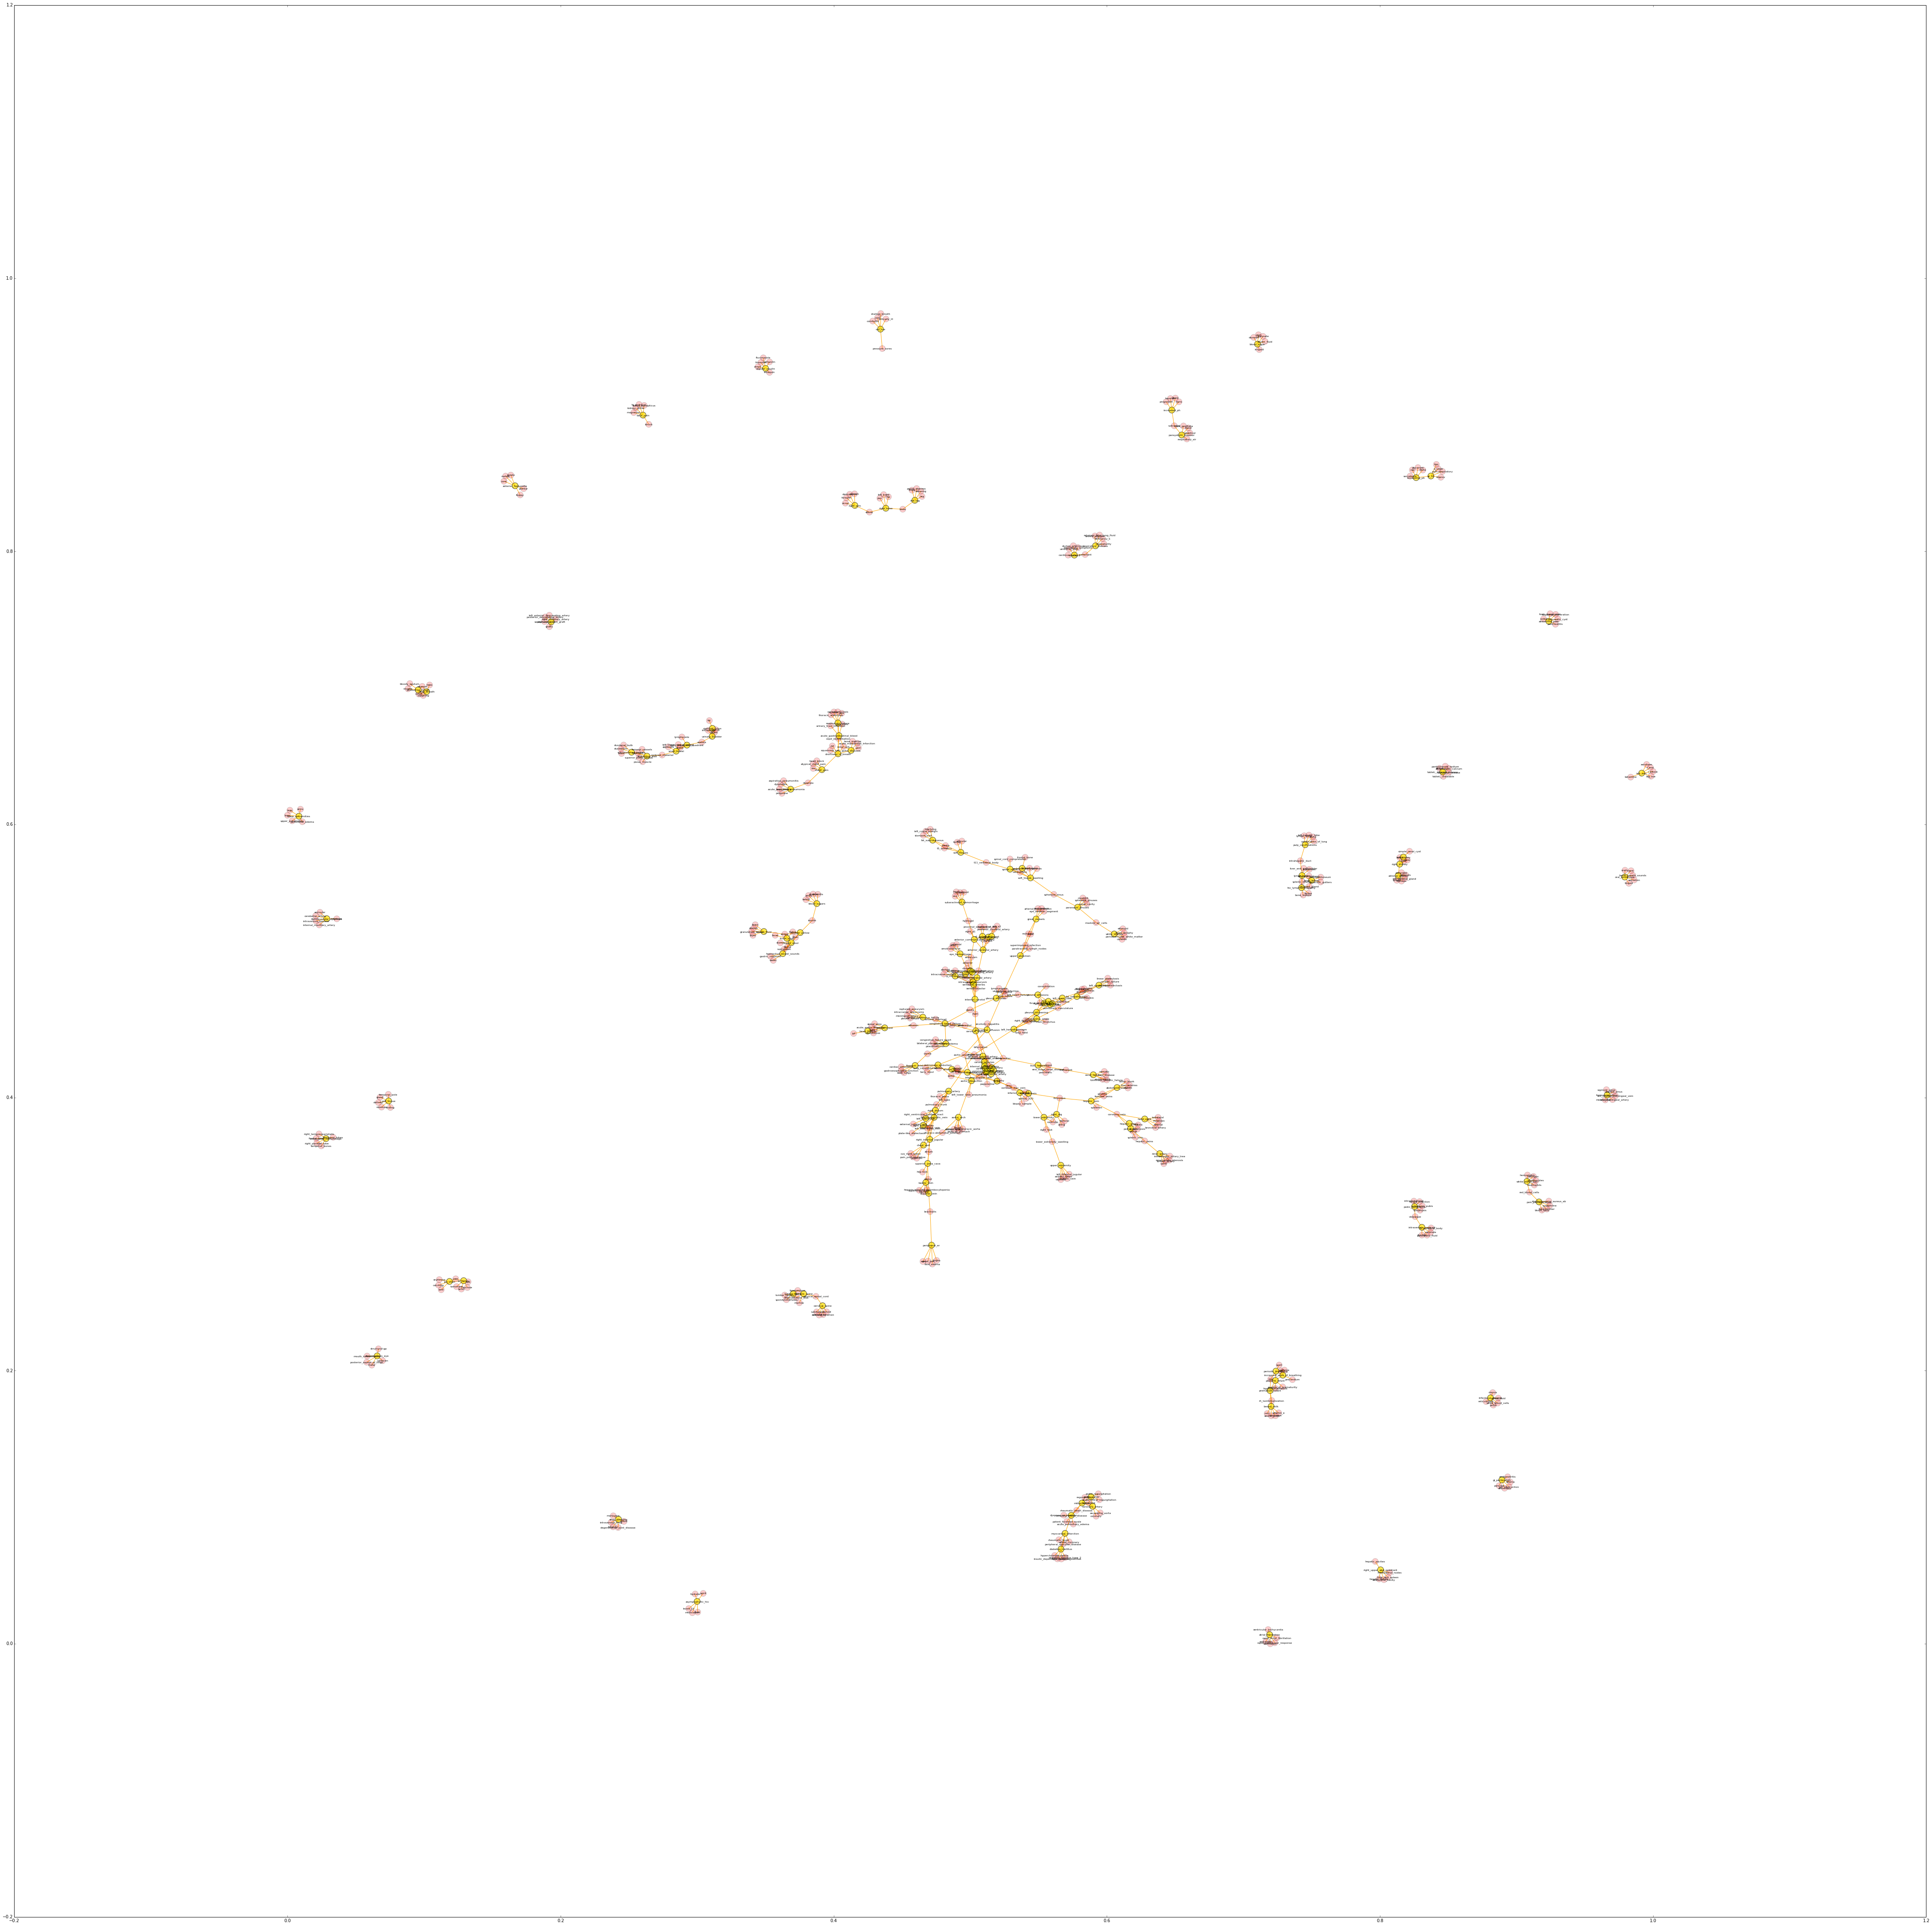

In [25]:
%matplotlib inline
import numpy as np
from pylab import *
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def get_relevant_terms(term,cnt):
    synonyms=[]
    try:
        synonyms = model.findSynonyms(term, cnt)
    except Exception as e:
        pass
    return synonyms

# construct the represeantion of the graph of concept relationships derived from related terms obtained from word2vec
# by selecting the top 5 most relevant concepts where the releavncy is >0.5 for the most frequent diseases and drugs concepts
# having a frequency > 100 in the input 100 notes

import networkx as nx
G=nx.Graph()
d_d=set()

for termf in most_frequent_terms:
    term = termf[0]
    if ' ' not in term or termf[1]<100:
        continue
#     print termf
    rel = get_relevant_terms(term,5)
#     print '\t',rel
    for tup in rel:
        if tup[1]>0.5:
#             print '\t\t',term.replace(' ','_'),tup[0].replace(' ','_')
            G.add_edge(term.replace(' ','_'),tup[0].replace(' ','_'),weight=round(tup[1],2))
            d_d.add(term.replace(' ','_'))
d_d_l=list(d_d)
try: 
#     pos = nx.graphviz_layout(G)
    pos = nx.spring_layout(G,iterations=100)
    plt.figure(figsize=(80,80))
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes (G,pos,alpha=0.2,node_color='red',node_size=200)
    nx.draw_networkx_nodes (G,pos,alpha=0.6,nodelist=d_d_l,node_color='yellow',node_size=200)
    nx.draw_networkx_labels(G,pos,alpha=0.4,label_color='grey',font_size=6)
    nx.draw_networkx_edges(G,pos,edge_color='orange',width = 1)
    plt.savefig("disease_drugs.png")
    plt.show()
except Exception as e: # matplotlib not available
    print e

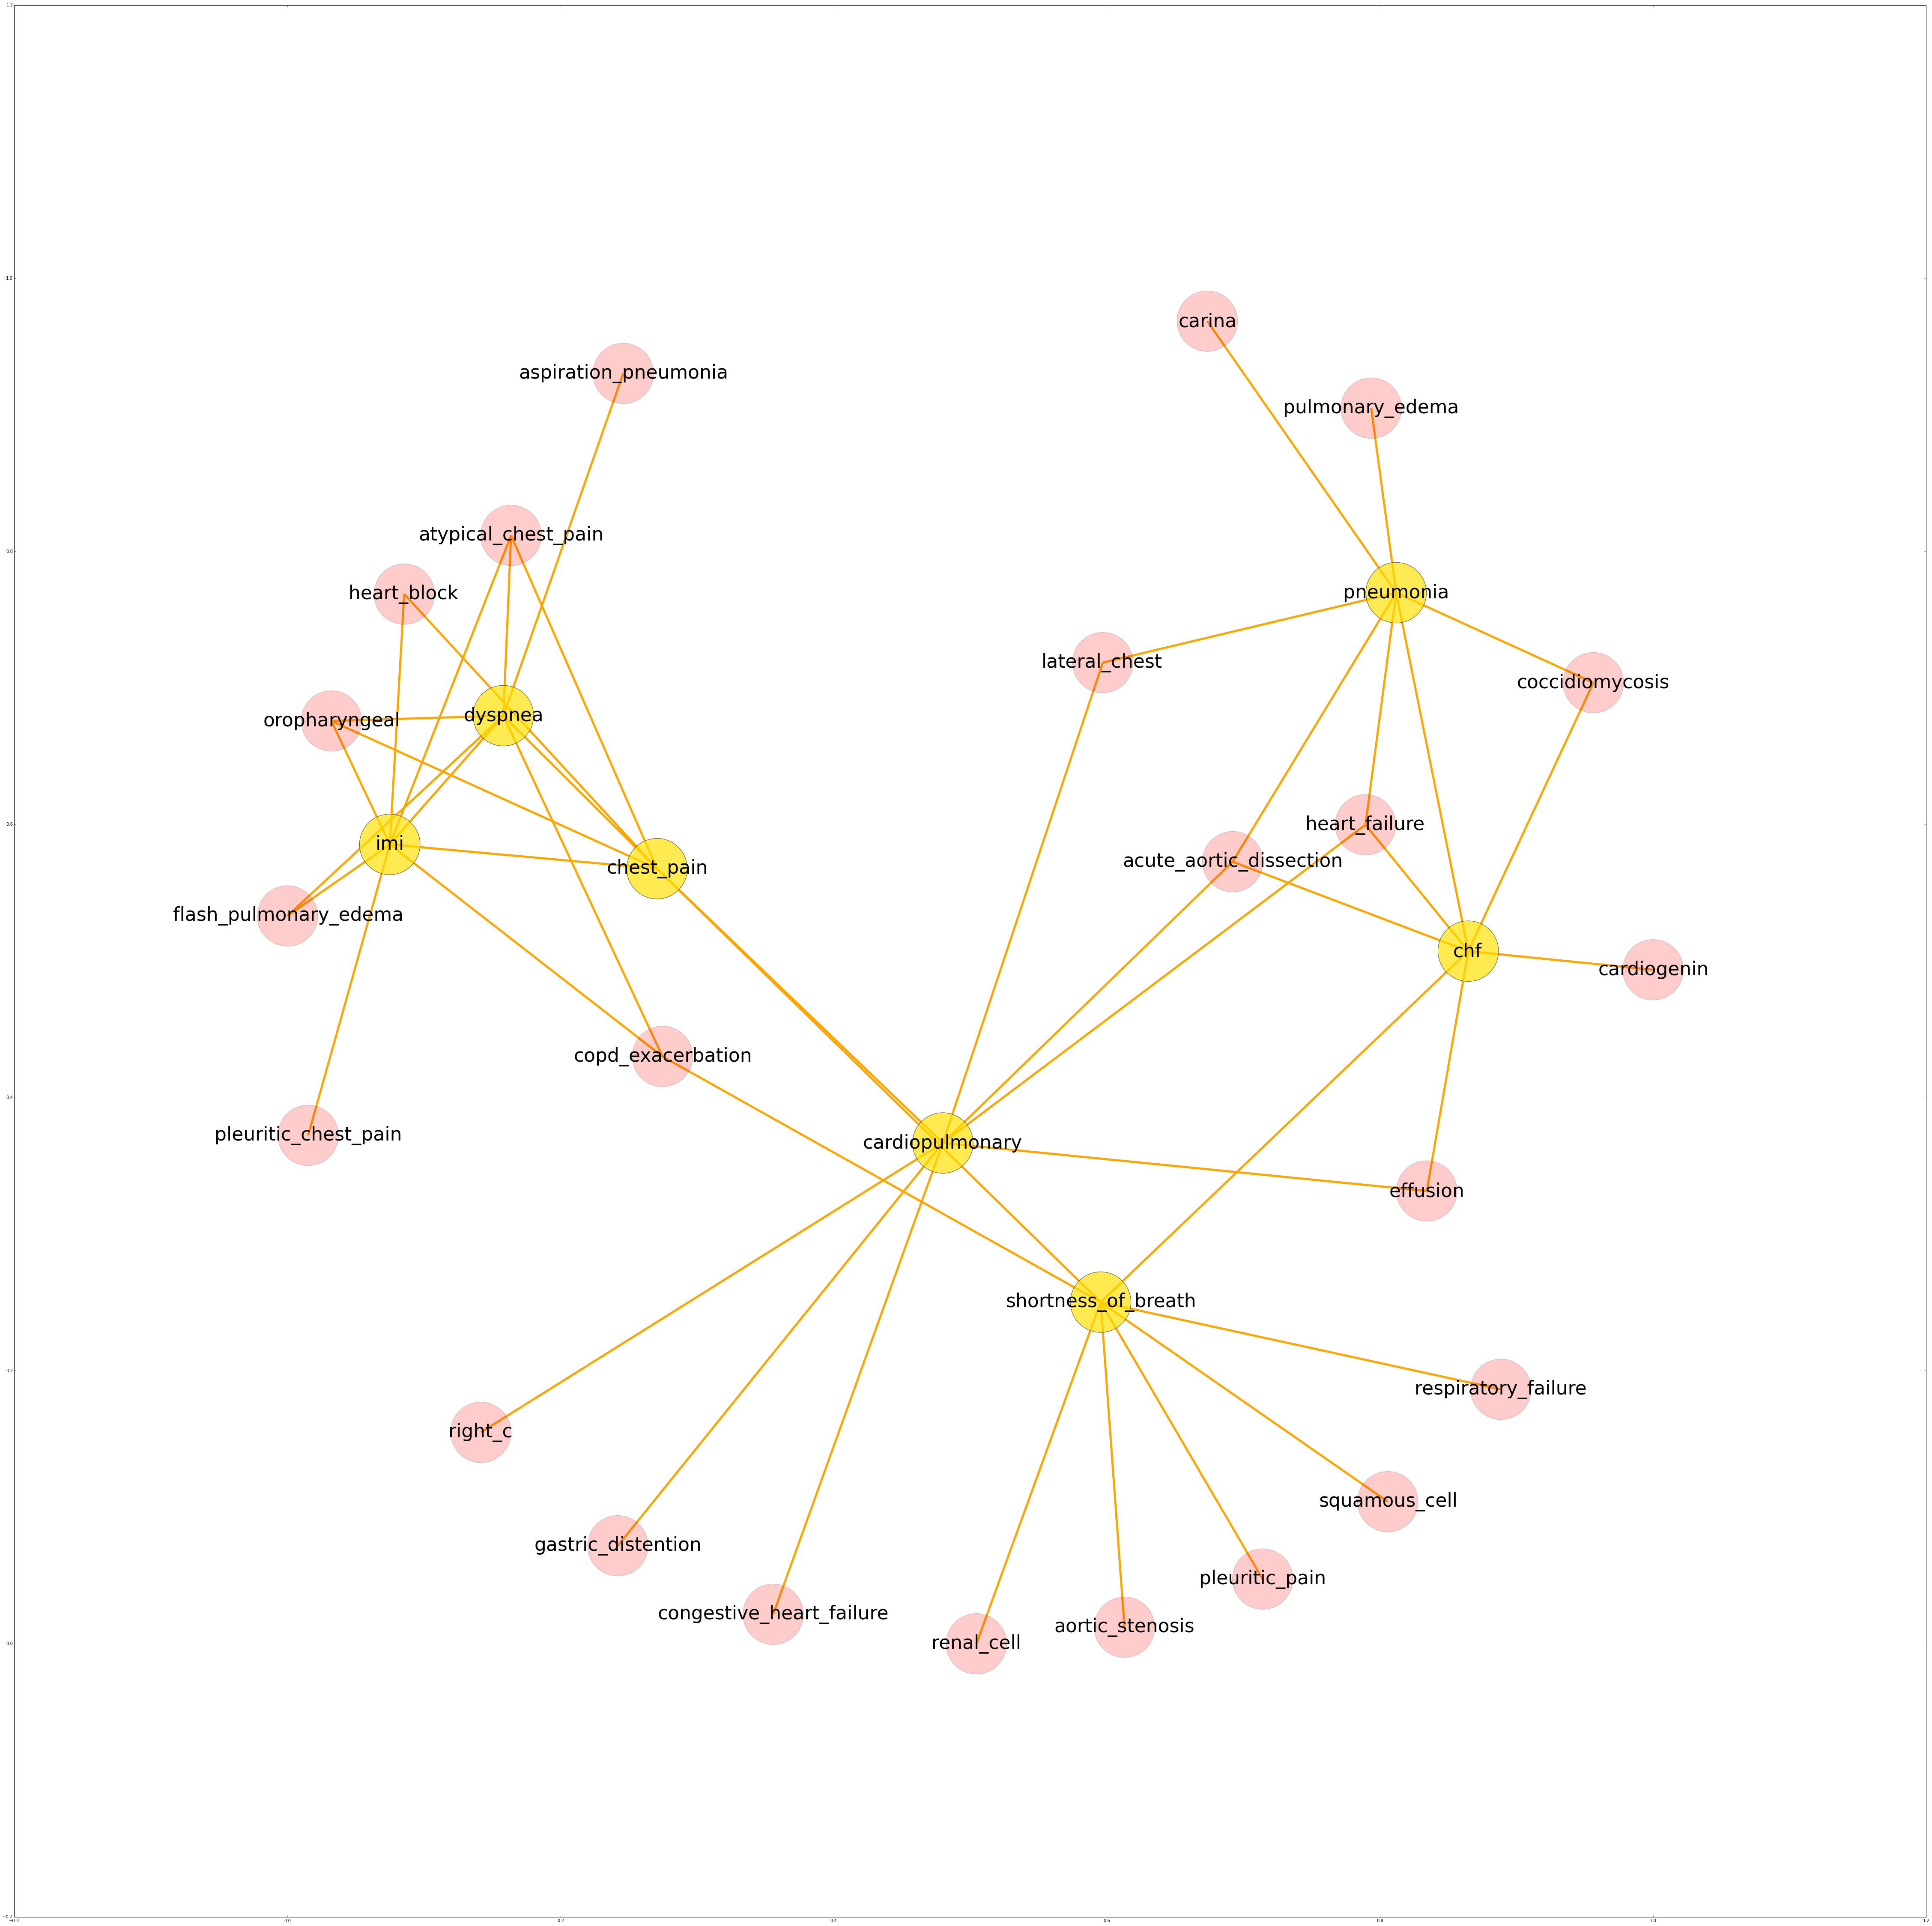

In [32]:
%matplotlib inline
import numpy as np
from pylab import *
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def get_relevant_terms(term,cnt):
    synonyms=[]
    try:
        synonyms = model.findSynonyms(term, cnt)
    except Exception as e:
        pass
    return synonyms

# construct the represeantion of the graph of concept relationships derived from related terms obtained from word2vec
# by selecting the top 5 most relevant concepts where the releavncy is >0.5 for the most frequent diseases and drugs concepts
# having a frequency > 100 in the input 100 notes

import networkx as nx
G=nx.Graph()
d_d=set()

for term in ['chest pain','shortness of breath','dyspnea','chf','cardiopulmonary','pneumonia','imi']:
    rel = get_relevant_terms(term,7)
#     print '\t',rel
    for tup in rel:
        if tup[1]>0.5:
#             print '\t\t',term.replace(' ','_'),tup[0].replace(' ','_')
            G.add_edge(term.replace(' ','_'),tup[0].replace(' ','_'),weight=round(tup[1],2))
            d_d.add(term.replace(' ','_'))
d_d_l=list(d_d)
try: 
#     pos = nx.graphviz_layout(G)
    pos = nx.spring_layout(G,iterations=100)
    plt.figure(figsize=(80,80))
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes (G,pos,alpha=0.2,node_color='red',node_size=20000)
    nx.draw_networkx_nodes (G,pos,alpha=0.6,nodelist=d_d_l,node_color='yellow',node_size=20000)
    nx.draw_networkx_labels(G,pos,alpha=0.4,label_color='grey',font_size=44)
    nx.draw_networkx_edges(G,pos,edge_color='orange',width = 5)
    plt.savefig("disease_drugs.png")
    plt.show()
except Exception as e: # matplotlib not available
    print e